# How are social & non-social decisions represented in the brain?

## NMA project

Analysis 1: which regions respond to social vs. non-social decisions? <br>
Analysis 2: can we predict behaviour from block to block using a Bayesian approach? <br>
Analysis 3: does a sliding window analysis reveal evidence accumulation? <br>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# 1. Initial setup

## 1.1 Define parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# 1.2 Download data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may <s>not</s> want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## 1.3 Load region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

## 1.4 Helper functions


In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs


In [ ]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
    """
    Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`
    
    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns: 
      un-normalized Gaussian evaluated at `x`
    """
    return np.exp(-(x_points-mu)**2/(2*sigma**2))

def moments_myfunc(x_points, function):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns the mean, median and mode of an arbitrary function

  Args : 
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """
  
  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x_points.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

def plot_myarray(array, xlabel, ylabel, title):
  """ Plot an array with labels.

  Args : 
    array (numpy array of floats) 
    xlabel (string) - label of x-axis
    ylabel (string) - label of y-axis
    title  (string) - title of plot

  Returns:
    None
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  colormap = ax.imshow(array, extent=[0, 3, 3, -3])
  cbar = plt.colorbar(colormap, ax=ax)
  cbar.set_label('probability')
  ax.invert_yaxis()
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_aspect('auto')
  return None

def plot_my_bayes_model(model) -> None:
  """Pretty-print a simple Bayes Model (ex 7), defined as a function:

  Args:
    - model: function that takes a single parameter value and returns 
             the negative log-likelihood of the model, given that parameter
  Returns: 
    None, draws plot
    """
  x = np.arange(-10,10,0.07)

  # Plot neg-LogLikelihood for different values of alpha
  alpha_tries = np.arange(0.01, 0.3, 0.01)
  nll = np.zeros_like(alpha_tries)
  for i_try in np.arange(alpha_tries.shape[0]):
    nll[i_try] = model(np.array([alpha_tries[i_try]]))

  plt.figure()
  plt.plot(alpha_tries, nll)
  plt.xlabel('p_independent value')
  plt.ylabel('negative log-likelihood')

  # Mark minima
  ix = np.argmin(nll)
  plt.scatter(alpha_tries[ix], nll[ix], c='r', s=144)

  #plt.axvline(alpha_tries[np.argmin(nll)])
  plt.title('Sample Output')
  plt.show()

  return None


def plot_simulated_behavior(true_stim, behaviour):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(1,1,1)
  ax.set_facecolor('xkcd:light grey')
  plt.plot(true_stim, true_stim - behaviour, '-k', linewidth=2, label='data')
  plt.axvline(0, ls='dashed', color='grey')
  plt.axhline(0, ls='dashed', color='grey')
  plt.legend()
  plt.xlabel('Position of true visual stimulus (cm)')
  plt.ylabel('Participant deviation from true stimulus (cm)')
  plt.title('Participant behavior')
  plt.show()

  return None

In [ ]:
#@title Helper functions

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Brain region")
  f.tight_layout()


def plot_function(f, name, var, points=(0, 3)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load behavior 

Loads behavioral array

In [ ]:
# Creating data dictionaries
# Behavioral Responses: goal - each row a trial, SubID, Run, Response
# if mental video, but mental_resp = 0 accuracy

# SUB ID   trial     run   trialType      response             acc   onset
#   0      1 - 10    1-2    mental/rnd    mental/rnd/unsure    0/1   46.008
#   1
#   2

# trial dictionary
runs = [0,1]
trial_dict = {'onset':[], 'duration':[], 'amplitude':[], 'trialType': [], 'runs':[], 'subject':[]} #'respOnset':[], 'acc':[]
trial_dict_labels = ['onset', 'duration', 'amplitude']
trial_conditions = ["rnd", "mental"]

for subject in subjects:
  for run in runs:
    for condition in trial_conditions: # for one SubID for one run
      # load trial data
      loaded_evs = load_evs(subject, 'social', condition)

      # labels
      for label in trial_dict_labels:
        trial_dict[label].extend(loaded_evs[run][label])

      # trialType
      trialTypesArr = np.ones(len(loaded_evs[run][label])) #get arr of ones
      # 1: mental, 2: rnd
      if condition == "rnd": 
        trialTypesArr = trialTypesArr * 2
      trial_dict["trialType"].extend(trialTypesArr)

    # run number
    runsArr = np.ones(5) #initialize array with ones
    # run = 0 => 1, run = 1 => 2
    if run == 1:
      runsArr = runsArr * 2
    trial_dict["runs"].extend(runsArr)

  #subject number
  subArr = np.ones(10) #initalize subject array
  subArr = subArr * (subject)
  trial_dict['subject'].extend(subArr)

#response dictionary
resp_dict = {'onset':[], 'duration':[], 'amplitude':[], 'respType': [], 'runs':[], 'subject':[]}
resp_conditions = ["other_resp", "mental_resp"]
resp_dict_labels = ['onset', 'duration', 'amplitude']
my_labels = ['onset', 'duration', 'amplitude', 'respType', 'runs', 'subject']

for subject in subjects:
  sub_resp_counter = 0
  for run in runs:
    run_resp_counter = 0
    for condition in resp_conditions: # for one SubID for one run
      # print(subject, run, condition)

      # load trial data
      loaded_evs = load_evs(subject, 'social', condition)

      if bool(loaded_evs[run]): #if responses exist of this condition type
        # labels
        for label in resp_dict_labels:
          if isinstance(loaded_evs[run][label], np.float64):
            resp_dict[label].append(loaded_evs[run][label])
          else:
            resp_dict[label].extend(loaded_evs[run][label])

        # respType
        if isinstance(loaded_evs[run][label], np.float64):
          respTypesArr = np.ones(1)
        else:
          respTypesArr = np.ones(len(loaded_evs[run][label])) #get arr of ones

        # 1: mental_Resp, 2: other_resp
        if condition == "other_resp": 
          respTypesArr = respTypesArr * 2
        resp_dict["respType"].extend(respTypesArr)

        # keep track of how many responses there were this run
        run_resp_counter += len(respTypesArr)

    # run number
    runsArr = np.ones(run_resp_counter) #initialize array with ones
    # run = 0 => 1, run = 1 => 2
    if run == 1:
      runsArr = runsArr * 2
    resp_dict["runs"].extend(runsArr)

    # count how many responses both runs
    sub_resp_counter += run_resp_counter

  #subject number
  subArr = np.ones(sub_resp_counter) #initalize subject array
  subArr = subArr * (subject)
  resp_dict['subject'].extend(subArr)

#convert dict to pd dataframe
trial_df = pd.DataFrame.from_dict(trial_dict)
# print(trial_df)

resp_df = pd.DataFrame.from_dict(resp_dict)
# print(resp_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/6/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/37/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/86/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/86/EVs/tfMRI_SOCIAL_LR/mental_resp.txt"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/151/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/155/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"
/usr/loca

In [ ]:
#joining dictionaries
joined_df = pd.merge(trial_df, resp_df, how='left',left_on=['subject','runs','onset','duration','amplitude'],right_on=['subject','runs','onset','duration','amplitude'])

# add accuracies
joined_df['acc'] = joined_df.trialType == joined_df.respType
joined_df['acc'] = joined_df['acc'].astype(int)

#sort by onsets within participant by run
joined_df = joined_df.sort_values(['subject','runs'], ascending = True) \
  .groupby(['subject','runs'], sort = True) \
  .apply(lambda x: x.sort_values(['onset'], ascending=True)) \
  .reset_index(drop=True)

# print dictionary
joined_df
#joined_df[joined_df['subject'] == 6]

#print(np.shape(joined_df))
droppedNA_df = joined_df.dropna()
err_df = droppedNA_df[(droppedNA_df['acc'] == 0) & (droppedNA_df['trialType']==2.0)]


## Bayesian behavior analysis

In [ ]:
droppedNA_df = joined_df.dropna()
droppedNA_df[droppedNA_df.acc == 0]
# droppedNA[droppedNA.acc == 0]

# Get inaccuracte subjects 
inacc_df = droppedNA_df[droppedNA_df.acc == 0]

grouped = joined_df.groupby('subject')
grouped_filter = pd.DataFrame(grouped.filter(lambda x: x['acc'].mean() < 1.))


In [ ]:
## CODE TESTING CELL on one subject - DELETE LATER
test_df = grouped_filter[grouped_filter.subject == 4]
test_df

trialType_arr = []
trialType_ave = []

for index, row in test_df.iterrows():
  #print(row['trialType'])
  if row['acc'] == 1:
    trialType_arr = np.append(trialType_arr, row['trialType'])
  else:
    trialType_ave = np.mean(trialType_arr)
    current_trialType = row['trialType']
    current_onset = row['onset']
    break

print(current_onset)

122.059


In [ ]:
#### Get average of trial types prior to subjects making a mistake

def mean_function(df):
  trialType_arr = [] # initialize array & average values
  for index, row in df.iterrows(): # loop through rows
    if row['acc'] == 1:
      trialType_arr = np.append(trialType_arr, row['trialType']) # if accurate, append current trialType
    else:
      trialType_ave = np.mean(trialType_arr) # if current response inaccurate, calculate average of trial types so far
      current_trialType = row['trialType']
      current_onset = row['onset']
      break # take only first error, skip to next subject
  return trialType_ave

prior_vals = grouped_filter.groupby('subject').apply(mean_function)
prior_vals_df = pd.DataFrame(prior_vals, columns= ['trial_ave'])
prior_vals_df
#print(type(prior_vals))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,trial_ave
subject,
2.0,1.428571
4.0,1.666667
5.0,1.500000
6.0,NaN
9.0,1.666667
...,...
328.0,1.500000
333.0,1.000000
334.0,1.500000


In [ ]:
def countTrials_function(df):
  trialType_arr = [] # initialize array & average values
  for index, row in df.iterrows(): # loop through rows
    if row['acc'] == 1:
      trialType_arr = np.append(trialType_arr, row['trialType']) # if accurate, append current trialType
    else:
      return len(trialType_arr) # if current response inaccurate, calculate average of trial types so far
      

tt_counts = grouped_filter.groupby('subject').apply(countTrials_function)
tt_countdf = pd.DataFrame(tt_counts,columns= ['tt_counts'])
tt_countdf

,tt_counts
subject,
2.0,7
4.0,3
5.0,4
6.0,0
9.0,3
...,...
328.0,4
333.0,1
334.0,4


In [ ]:
#### Get average of trial types prior to subjects making a mistake

def trialType_function(df):
  for index, row in df.iterrows(): # loop through rows
    if row['acc'] != 1:
      return row['trialType']

trialType_vals = grouped_filter.groupby('subject').apply(trialType_function)
trialType_df = pd.DataFrame(trialType_vals, columns= ['trialType'])
trialType_df

,trialType
subject,
2.0,2.0
4.0,1.0
5.0,2.0
6.0,1.0
9.0,1.0
...,...
328.0,2.0
333.0,2.0
334.0,2.0


In [ ]:
def respType_function(df):
  for index, row in df.iterrows(): # loop through rows
    if row['acc'] != 1:
      return row['respType']

respType_vals = grouped_filter.groupby('subject').apply(respType_function)
respType_df = pd.DataFrame(respType_vals, columns= ['respType'])
respType_df

,respType
subject,
2.0,1.0
4.0,2.0
5.0,1.0
6.0,NaN
9.0,2.0
...,...
328.0,NaN
333.0,NaN
334.0,1.0


In [ ]:
#merged_df = pd.merge(prior_vals_df, tt_countdf, trialType_df, on='subject')
horizontal_stack = pd.concat([prior_vals_df, tt_countdf, trialType_df, respType_df], axis=1)
horizontal_stack

,trial_ave,tt_counts,trialType,respType
subject,,,,
2.0,1.428571,7,2.0,1.0
4.0,1.666667,3,1.0,2.0
5.0,1.500000,4,2.0,1.0
6.0,NaN,0,1.0,NaN
9.0,1.666667,3,1.0,2.0
...,...,...,...,...
328.0,1.500000,4,2.0,NaN
333.0,1.000000,1,2.0,NaN
334.0,1.500000,4,2.0,1.0


In [ ]:
horizontal_stack['subject'] = horizontal_stack.index
horizontal_stack = horizontal_stack.reset_index(drop=True)
horizontal_stack = horizontal_stack.dropna()
horizontal_stack
#horizontal_stack[4.0,:]

,trial_ave,tt_counts,trialType,respType,subject
0,1.428571,7,2.0,1.0,2.0
1,1.666667,3,1.0,2.0,4.0
2,1.500000,4,2.0,1.0,5.0
4,1.666667,3,1.0,2.0,9.0
5,1.666667,3,1.0,2.0,10.0
...,...,...,...,...,...
148,1.500000,4,2.0,1.0,324.0
149,1.000000,1,2.0,1.0,325.0
150,1.666667,3,1.0,2.0,326.0
153,1.500000,4,2.0,1.0,334.0


In [ ]:
social_tempDf = horizontal_stack[horizontal_stack['trialType'] == 1.0]
rnd_tempDf = horizontal_stack[horizontal_stack['trialType'] == 2.0]
print(np.shape(social_tempDf))
print(np.shape(rnd_tempDf))

(57, 5)
(36, 5)


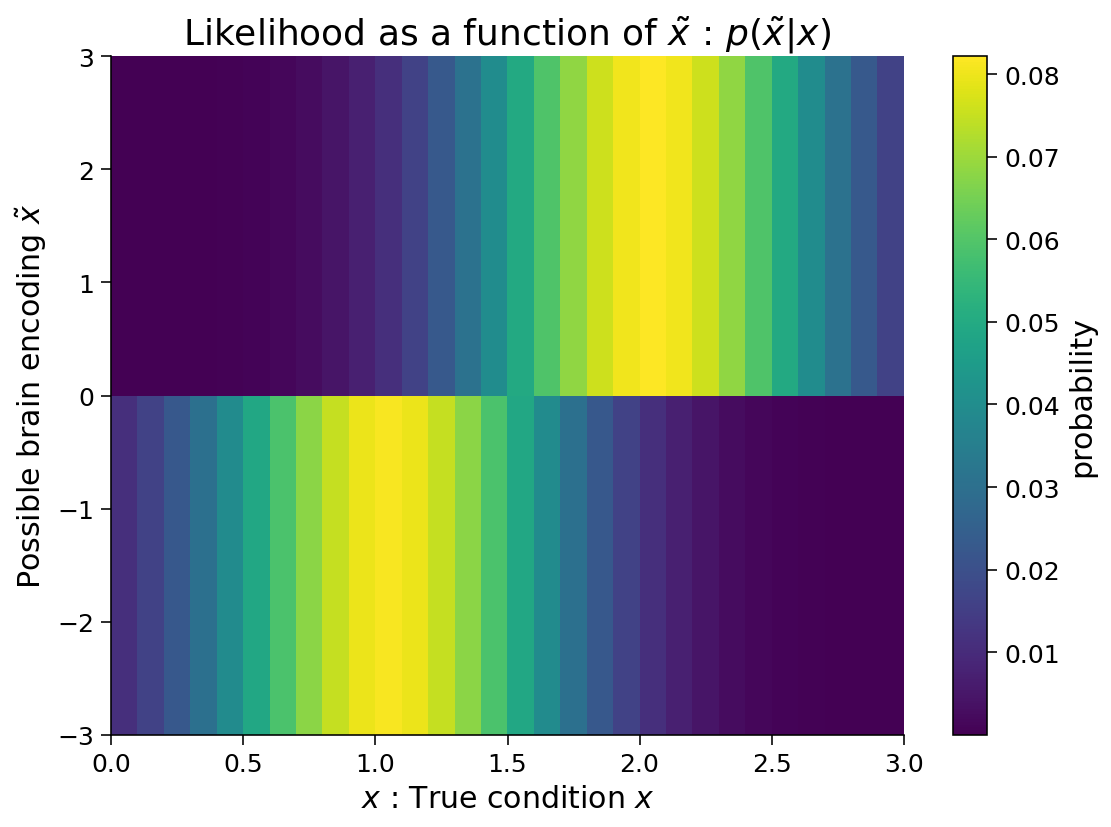

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)

def compute_likelihood_array(x_points, stim_array, sigma=.5):
  likelihood_array = np.zeros((len(stim_array), len(x_points)))
  for i in range(len(stim_array)):
    likelihood_array[i, :] = my_gaussian(x_points, stim_array[i], sigma)
    likelihood_array[i, :] = likelihood_array[i,:]/np.sum(likelihood_array[i,:]) # normalize

  return likelihood_array

likelihood_array = compute_likelihood_array(x_points, stim_array)
plot_myarray(likelihood_array,
            '$x$ : True condition $x$',
            'Possible brain encoding $\~x$',
            'Likelihood as a function of $\~x$ : $p(\~x | x)$')

In [ ]:
x_points

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9])

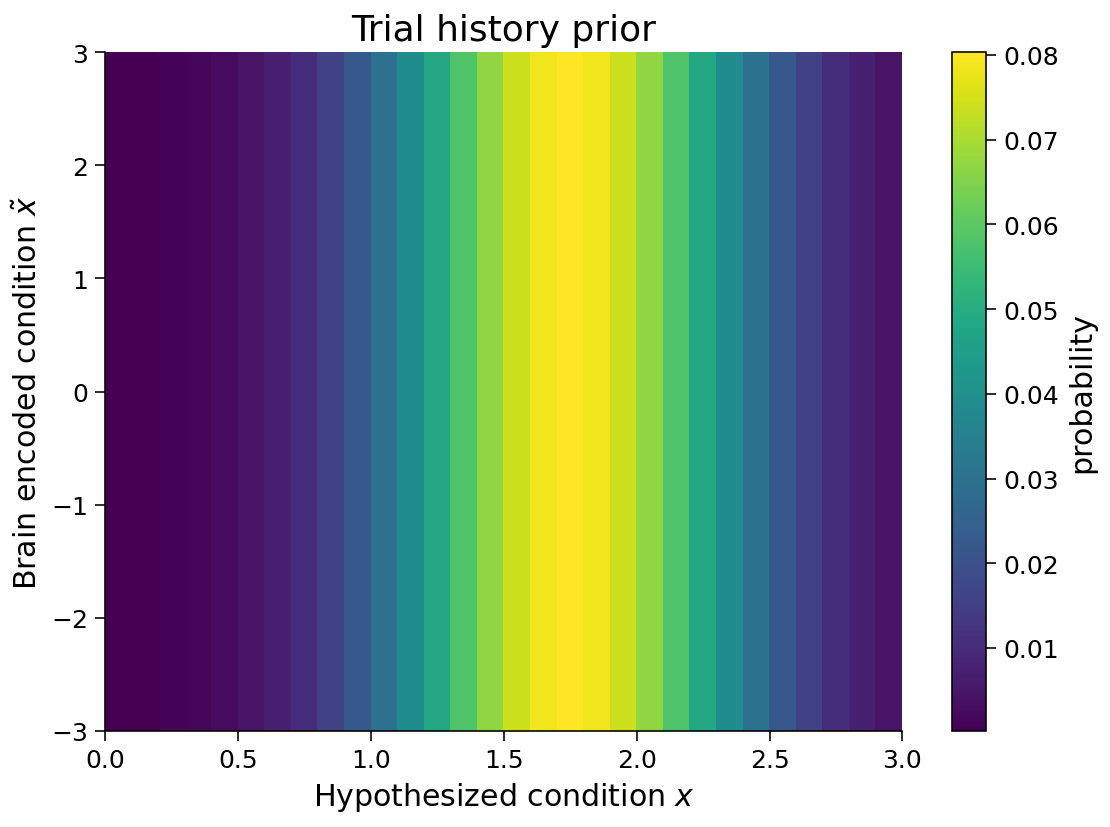

In [ ]:
x_points = np.arange(0, 3, 0.1)


def calculate_prior_array(x_points, mean, sigma):

    prior_trial = my_gaussian(x_points, mean, sigma)
    prior_trial = prior_trial/ np.sum(prior_trial)
    
    prior_array = np.tile(prior_trial, len(stim_array)).reshape(len(stim_array), -1)
    return prior_array



# Uncomment following lines, once the task is complete.
prior_array = calculate_prior_array(x_points, 1.7 ,.5)
plot_myarray(prior_array,
             'Hypothesized condition $x$', 'Brain encoded condition $\~x$',
             'Trial history prior')



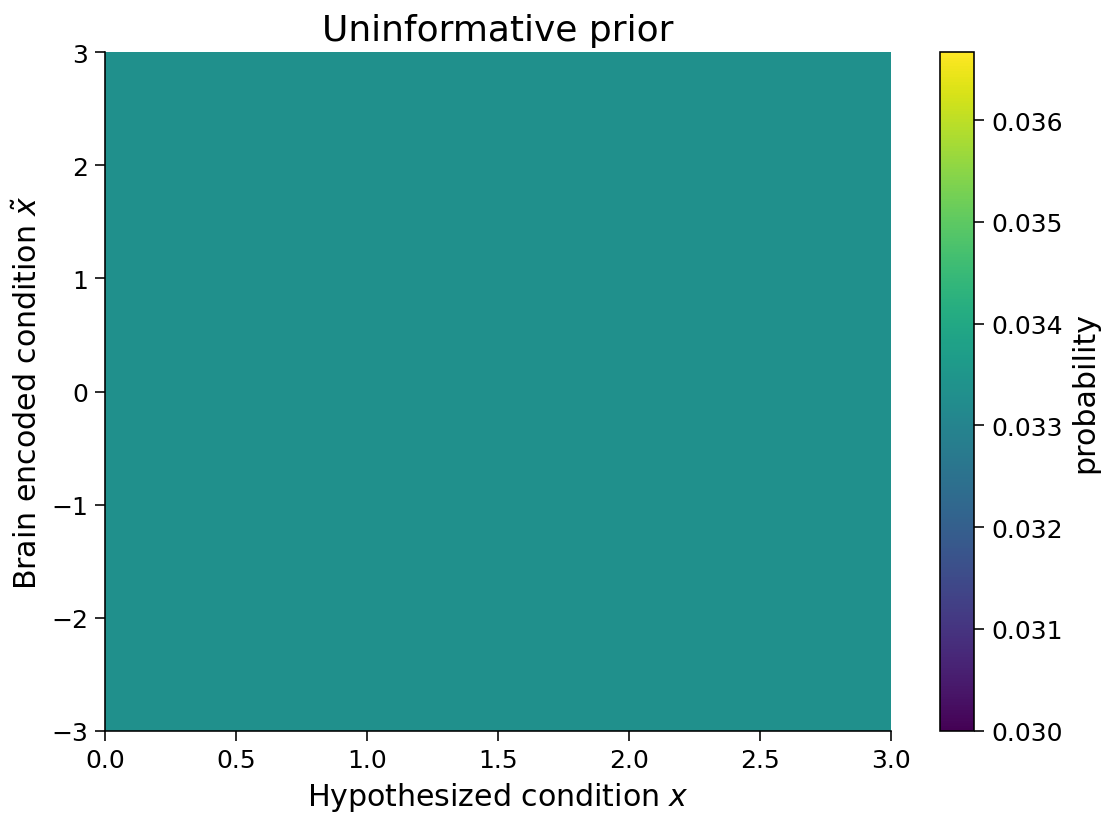

In [ ]:
x_points = np.arange(0, 3, 0.1)


def uninform_prior(x_points):
    uninform_array = np.ones(len(x_points))
    uninform_array = uninform_array/ np.sum(uninform_array)
    
    uninform_array = np.tile(uninform_array, len(stim_array)).reshape(len(stim_array), -1)
    return uninform_array



# Uncomment following lines, once the task is complete.
uninform_array = uninform_prior(x_points)
plot_myarray(uninform_array,
             'Hypothesized condition $x$', 'Brain encoded condition $\~x$',
             'Uninformative prior')

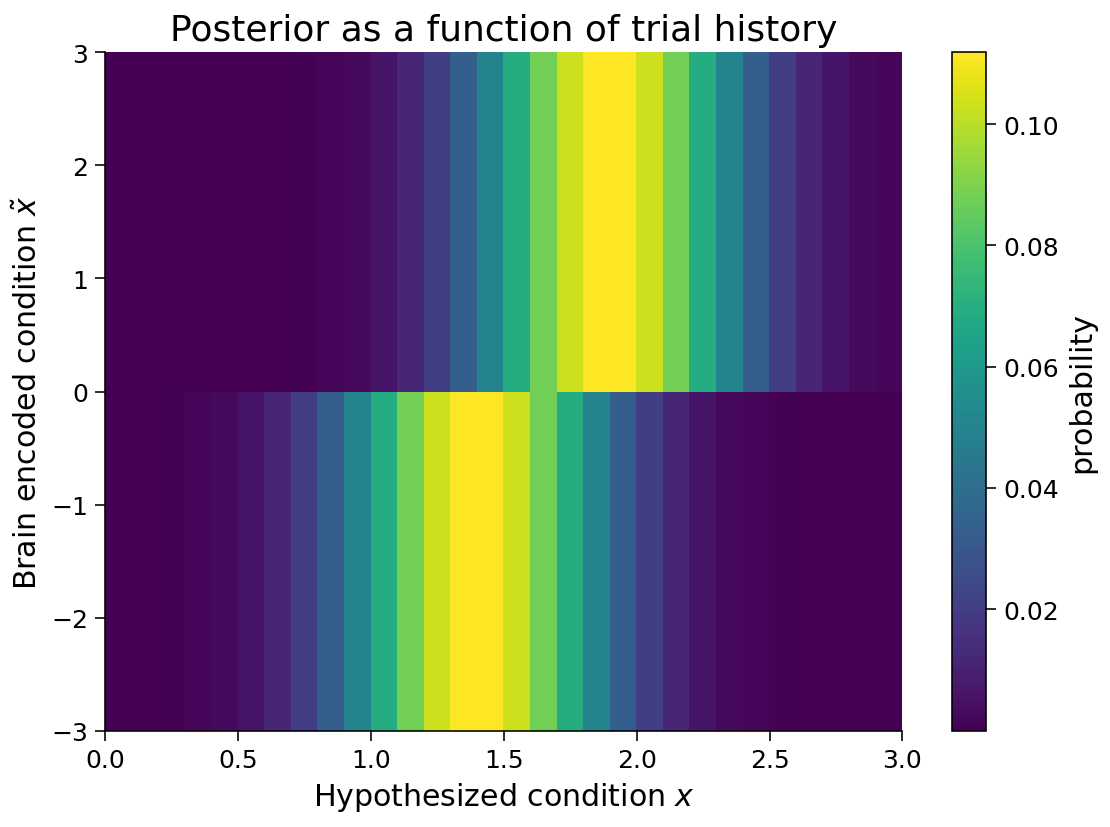

In [ ]:
def calculate_posterior_array(prior_array, likelihood_array):

    posterior_array = prior_array * likelihood_array
    posterior_array = posterior_array/np.sum(posterior_array, axis= 1, keepdims = True) # normalize each row separately

    return posterior_array

# Uncomment following lines, once the task is complete.
posterior_array = calculate_posterior_array(prior_array, likelihood_array)
plot_myarray(posterior_array,
             'Hypothesized condition $x$',
             'Brain encoded condition $\~x$',
             'Posterior as a function of trial history')

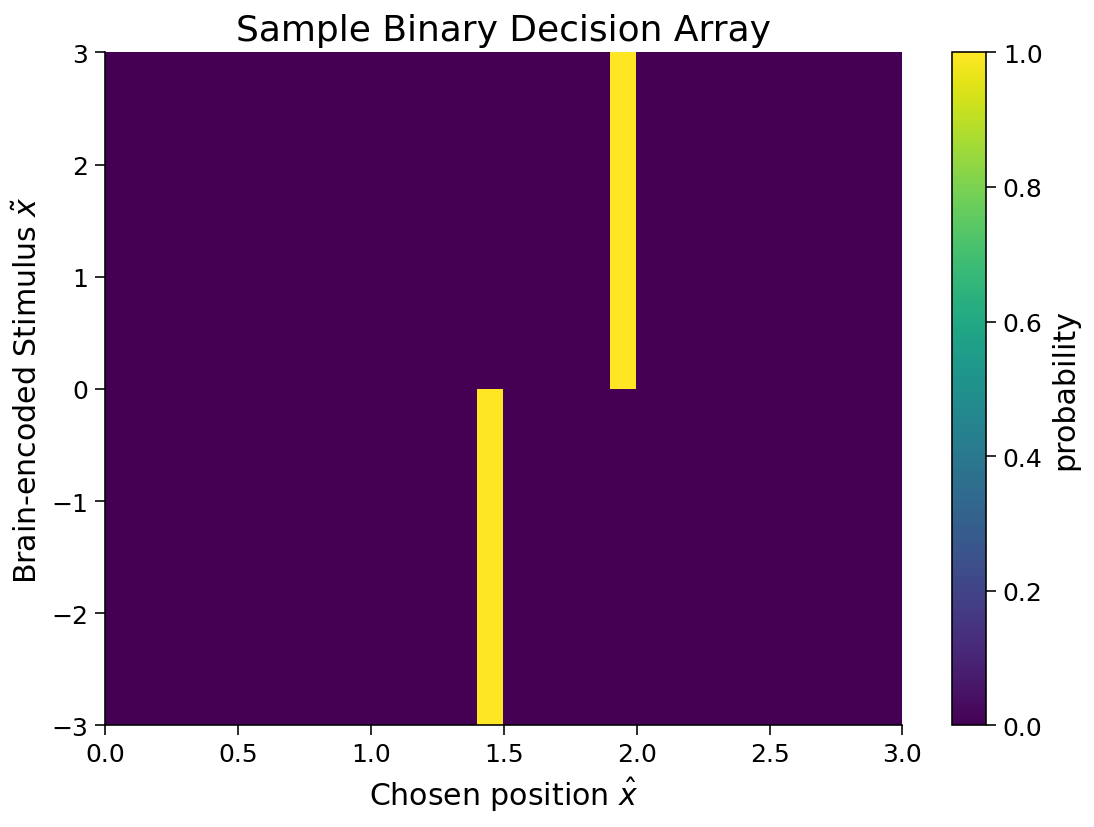

In [ ]:
def calculate_binary_decision_array(x_points, posterior_array):

    binary_decision_array = np.zeros_like(posterior_array)

    for i in range(len(posterior_array)):

        ########################################################################
        ## Insert your code here to:
        ##      - For each hypothetical stimulus x (row of posterior),
        ##        calculate the mean of the posterior using the povided function 
        ##        `moments_myfunc()`, and set the corresponding cell of the 
        ##        Binary Decision array to 1.
        ##        Hint: you can run 'help(moments_myfunc)' to see the docstring
        ## remove the raise below to test your function
        #raise NotImplementedError("You need to complete the function!")
        ########################################################################
        
        mean, _, _ = moments_myfunc(x_points, posterior_array[i]) # calculate mean of posterior using 'moments_myfunc'
        idx = np.argmin(np.abs(x_points - mean)) # find the postion of mean in x_points (closest position)
        binary_decision_array[i, idx] = 1 

    return binary_decision_array

# Uncomment following lines, once the task is complete.
binary_decision_array = calculate_binary_decision_array(x_points, posterior_array)
plot_myarray(binary_decision_array,
             'Chosen position $\hat x$', 'Brain-encoded Stimulus $\~ x$',
             'Sample Binary Decision Array')

Just Trial History Prior

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)
likelihood_array = compute_likelihood_array(x_points, stim_array)
sub_ll = np.zeros(len(horizontal_stack))

for i in range(len(horizontal_stack)):
  prevTrialsprob = horizontal_stack.iloc[i]['trial_ave']
  prevTrialscount = horizontal_stack.iloc[i]['tt_counts']
  prior_array = calculate_prior_array(x_points, prevTrialsprob ,.8/ prevTrialscount)
  posterior_array = calculate_posterior_array(prior_array, likelihood_array)
  action= horizontal_stack.iloc[i]['respType']
  idx = np.argmin(np.abs(x_points - action))
  sub_ll[i] = np.log(posterior_array[int(action) - 1, idx] + np.finfo(float).eps)
neg_11 = -sub_ll.sum()
neg_11

370.34923730226626

Trial History + Social Bias Prior

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)
likelihood_array = compute_likelihood_array(x_points, stim_array)
sub_ll = np.zeros(len(horizontal_stack))

for i in range(len(horizontal_stack)):
  prevTrialsprob = horizontal_stack.iloc[i]['trial_ave']
  prevTrialscount = horizontal_stack.iloc[i]['tt_counts']
  prior_array = calculate_prior_array(x_points, prevTrialsprob ,.8/ prevTrialscount)
  socialBias_array = calculate_prior_array(x_points, 1 , .5)
  Jointprior_array = prior_array * socialBias_array
  posterior_array = calculate_posterior_array(Jointprior_array, likelihood_array)
  action= horizontal_stack.iloc[i]['respType']
  idx = np.argmin(np.abs(x_points - action))
  sub_ll[i] = np.log(posterior_array[int(action) - 1, idx] + np.finfo(float).eps)
neg_11 = -sub_ll.sum()
neg_11

418.9220583580862

Trial History + Random Bias Prior

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)
likelihood_array = compute_likelihood_array(x_points, stim_array)
sub_ll = np.zeros(len(horizontal_stack))

for i in range(len(horizontal_stack)):
  prevTrialsprob = horizontal_stack.iloc[i]['trial_ave']
  prevTrialscount = horizontal_stack.iloc[i]['tt_counts']
  prior_array = calculate_prior_array(x_points, prevTrialsprob ,.8/ prevTrialscount)
  rndBias_array = calculate_prior_array(x_points, 2 , .5)
  Jointprior_array = prior_array * rndBias_array
  posterior_array = calculate_posterior_array(Jointprior_array, likelihood_array)
  action= horizontal_stack.iloc[i]['respType']
  idx = np.argmin(np.abs(x_points - action))
  sub_ll[i] = np.log(posterior_array[int(action) - 1, idx] + np.finfo(float).eps)
neg_11 = -sub_ll.sum()
neg_11

400.101928950959

Just trial history no weighting

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)
likelihood_array = compute_likelihood_array(x_points, stim_array)
sub_ll = np.zeros(len(horizontal_stack))

for i in range(len(horizontal_stack)):
  prevTrialsprob = horizontal_stack.iloc[i]['trial_ave']
  prior_array = calculate_prior_array(x_points, 2 ,.5)
  posterior_array = calculate_posterior_array(prior_array, likelihood_array)
  action= horizontal_stack.iloc[i]['respType']
  idx = np.argmin(np.abs(x_points - action))
  sub_ll[i] = np.log(posterior_array[int(action) - 1, idx] + np.finfo(float).eps)
neg_11 = -sub_ll.sum()
neg_11

238.70640261252902

Uninformative Prior

In [ ]:
stim_array = [1,2]
x_points = np.arange(0,3,.1)
likelihood_array = compute_likelihood_array(x_points, stim_array)
sub_ll = np.zeros(len(horizontal_stack))

for i in range(len(horizontal_stack)):
  prevTrialsprob = horizontal_stack.iloc[i]['trial_ave']
  prior_array = uninform_prior(x_points)
  posterior_array = calculate_posterior_array(prior_array, likelihood_array)
  action= horizontal_stack.iloc[i]['respType']
  idx = np.argmin(np.abs(x_points - action))
  sub_ll[i] = np.log(posterior_array[int(action) - 1, idx] + np.finfo(float).eps)
neg_11 = -sub_ll.sum()
neg_11

232.84419422150916

In [ ]:
horizontal_stack.iloc[1]

trial_ave    1.666667
tt_counts    3.000000
trialType    1.000000
respType     2.000000
subject      4.000000
Name: 1, dtype: float64

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

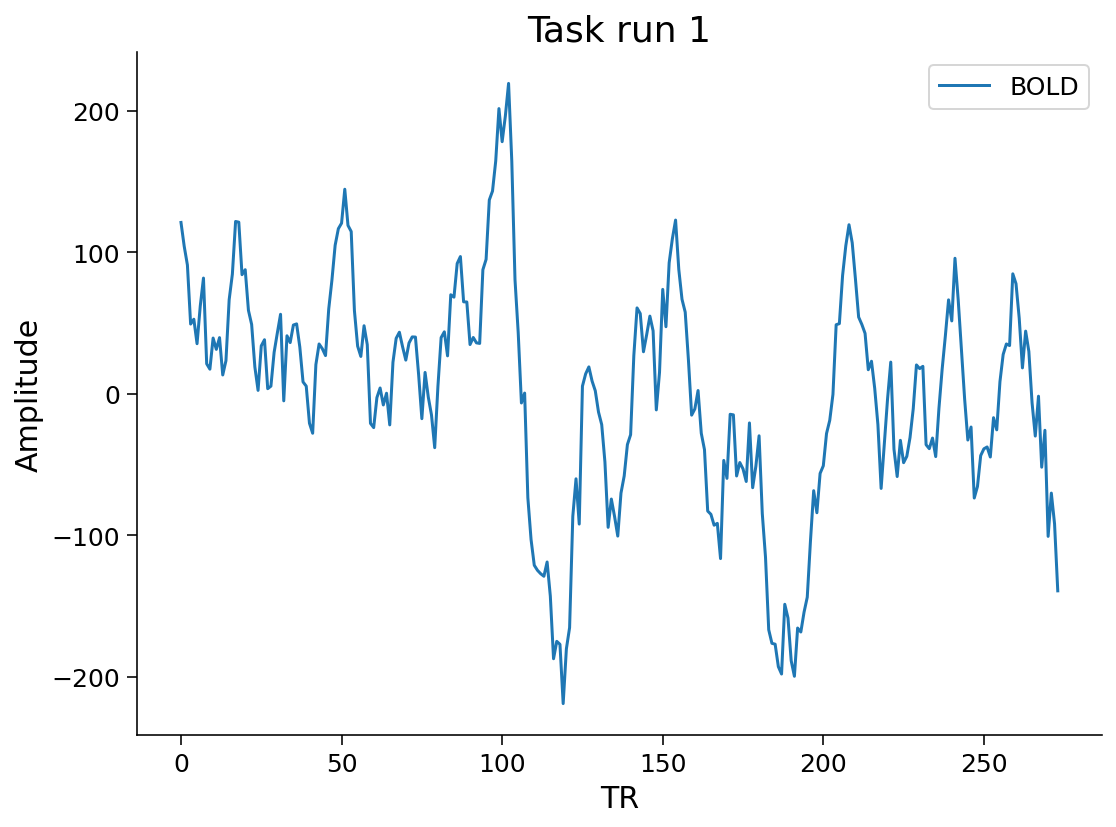

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "social", concat=False))

# test it works
# timeseries_task[:10]
timeseries_task[0][0][0]
run1 = timeseries_task[0][0][0]
plt.plot(run1, label=f"BOLD")
plt.title("Task run 1" )
plt.xlabel("TR")
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
sub0 = load_timeseries(0, 'social', runs=0, concat=True, remove_mean=True)
print(sub0)
print(np.shape(sub0))

[[ 121.14051095  104.34051095   91.04051095 ...  -70.15948905
   -91.85948905 -139.25948905]
 [-152.27959854 -159.69959854  -93.13959854 ...  -11.08959854
   -76.31959854  -96.76959854]
 [ 132.76970803  131.26970803    8.86970803 ...   93.36970803
    39.86970803   90.96970803]
 ...
 [ 229.93175182  114.83175182   78.33175182 ...   29.93175182
   -66.26824818  125.93175182]
 [ 113.68941606  105.48941606   48.88941606 ...  -70.41058394
    38.58941606  -47.31058394]
 [ 104.00620438  206.30620438  247.90620438 ...   39.40620438
   -63.89379562 -123.29379562]]
(360, 274)


In [ ]:
print(np.shape(timeseries_task))
# 339 participants, 2 runs, 360 regions, 274 TRs

(339, 2, 360, 274)


In [ ]:
evs = load_evs(1, 'social', 'mental')
print(evs[1])
np.shape(evs)

{'onset': array([  8.223,  46.008, 122.057]), 'duration': array([23., 23., 23.]), 'amplitude': array([1., 1., 1.])}


(2,)

In [ ]:
rndevs = load_evs(1, 'social', 'rnd')
print(rndevs)

[{'onset': array([ 46.008,  84.033, 160.082]), 'duration': array([23., 23., 23.]), 'amplitude': array([1., 1., 1.])}, {'onset': array([ 84.033, 160.082]), 'duration': array([23., 23.]), 'amplitude': array([1., 1.])}]


In [ ]:
mentalRespEvs = load_evs(6, 'social', 'mental_resp')
print(mentalRespEvs)

[{}, {'onset': array([  8.224,  46.008, 122.057]), 'duration': array([23., 23., 23.]), 'amplitude': array([1., 1., 1.])}]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: UserWarning: genfromtxt: Empty input file: "./hcp/subjects/6/EVs/tfMRI_SOCIAL_RL/mental_resp.txt"


In [ ]:
OtherRespEvs = load_evs(6, 'social', 'other_resp')
print(OtherRespEvs)

[{'onset': array([ 46.007,  84.032, 122.056, 160.081]), 'duration': array([23., 23., 23., 23.]), 'amplitude': array([1., 1., 1., 1.])}, {'onset': array([ 84.033, 160.081]), 'duration': array([23., 23.]), 'amplitude': array([1., 1.])}]


### <b> Extracting BOLD per Region per SubID <b> <br> csv including (SubID, TrialType, Response, RegionName, MeanActivity)


In [ ]:
## EXTRACT TIME SERIES FOR EACH TRIAL 

## shape of data
#  X matrix with shape (n_samples, n_features) = (trials, regions)
# a y vector with length n_samples. (trial resps)
# y = data["choices"]
# X = data["spikes"]

# SUB ID   trial    run   trialType    response   region1   region2 region3    
#   0      1        1     mental       mental       m(act1)   ...   ...
#   0      2        1     rnd           rnd         m(act1)   ...   ...
#   0      3        1     mental       mental       m(act1)   ...   ...

conditions = ["mental", "rnd"]  # two video conditions (not subj responses)
runs = [0, 1] 
regions = range(0,360) # Glasser regions
tempsubject = range(0,1)
ts_means = np.empty([len(joined_df), len(regions)])
row_counter = 0 

for subject in subjects:
  sub_counter = 0
  #print('sub', subject)

  for run in runs:
    # Loads data for subject in run 
    current_data = load_timeseries(subject, 'social', runs=run, concat=True, remove_mean=True) # time series
    behav_current = joined_df[(joined_df['subject'] == subject) & (joined_df['runs'] == run+1)].reset_index() # behavior 

    # Seperate out row indices of time series by condition 
    # mental
    condition_idx_mental = condition_frames(load_evs(subject, "social", conditions[0]), skip=0)
    run_idx_mental = condition_idx_mental[run] # identify rows corresponding to mental condition
    condition_data_mental = current_data[: ,run_idx_mental] # grab correct rows
    
    # random
    condition_idx_rnd = condition_frames(load_evs(subject, "social", conditions[1]), skip=0)
    run_idx_rnd = condition_idx_rnd[run]
    condition_data_rnd = current_data[:, run_idx_rnd]
    
    # Start trial number to index to cut into blocks - resets to 0 each run
    start_val_mental = 0
    start_val_rnd = 0

    #print('run', run)
    # print('rnd total' , np.shape(condition_data_rnd)) # [360 x 96] or [360 x 64]
    # print('mental total', np.shape(condition_data_mental))
    #print('num trials in run:', len(behav_current))

    for trial in range(0,len(behav_current)): # loop over rows of behavioral data (each trial)

      # Seperate out date for this trial 
      condition_current = int(behav_current['trialType'][trial])

      # ID condition of date & pull the relevant time series data out 
      if condition_current == 1:
        trial_mental_temp = condition_data_mental[:,start_val_mental:start_val_mental+32]
        start_val_mental = start_val_mental+32
        c_trial_means = np.mean(trial_mental_temp, axis=1) # array of 360 regions for this trial

      else:
        trial_rnd_temp = condition_data_rnd[:,start_val_rnd:start_val_rnd+32]
        start_val_rnd = start_val_rnd+32
        c_trial_means = np.mean(trial_rnd_temp, axis=1) # array of 360 regions for this trial

      ts_means[row_counter,:] = c_trial_means
      row_counter = row_counter +1

In [ ]:
## JOIN RESP + ACC + REGION TIME SERIES

# Create resp array
resps = joined_df['respType']

# Create accuracy array
accs = joined_df['acc']

subs = joined_df['subject']

# Combine time series means & responses in df frame [3390 trials x 360 regions + 1 col resp + 1 col accs]
behav_plus_ts = np.hstack((resps[:,None], accs[:,None], subs[:,None], ts_means))

# Filter incorrect & NaN responses
acc_idx = np.where(behav_plus_ts[:,1]==1)[0]
filter_behav_ts = behav_plus_ts[acc_idx]

#print('raw', np.shape(behav_plus_ts))
#print('filter', np.shape(filter_behav_ts))



In [ ]:
# define non-social, social, and other higher-order cortical regions
# filter all data to only include columns with those regions

non_socialidx = [0,1,2,3,10,11,12,13,26,45,112,127,183,190,191,192,193,206,225,292,307]
non_social_array = filter_behav_ts[:,non_socialidx]

socialidx = [0,1,2,29,95,130,131,132,141,142,143,178, 209,275,310,311,312,321,322,323,358]
social_array = filter_behav_ts[:,socialidx]

otheridx = [0,1,2, 16,92, 120, 121,122, 128,129,157,168, 196,272,300, 301,302,308,309,337,348]
other_array = filter_behav_ts[:,otheridx]
np.shape(other_array)

(3142, 21)

## Logistic regression to distinguish social vs non social

In [ ]:
## LOGISTIC REGRESSION TO CLASSIFY SOCIAL VS NON SOCIAL 
# Seperate into training & test set (by subject)
X = filter_behav_ts[:,4:]
y = filter_behav_ts[:,0]

print('X', np.shape(X))
print('y', np.shape(y))

# Logistic regression -- day 4 tutorial 2 
log_reg_all = LogisticRegression(penalty="none")
log_reg_all.fit(X, y)

X (3142, 359)
y (3142,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)
  accuracy = np.mean([y == y_pred])

  return accuracy

# Uncomment and run to test your function:
train_accuracy = compute_accuracy(X, y, log_reg_all)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 100.00%


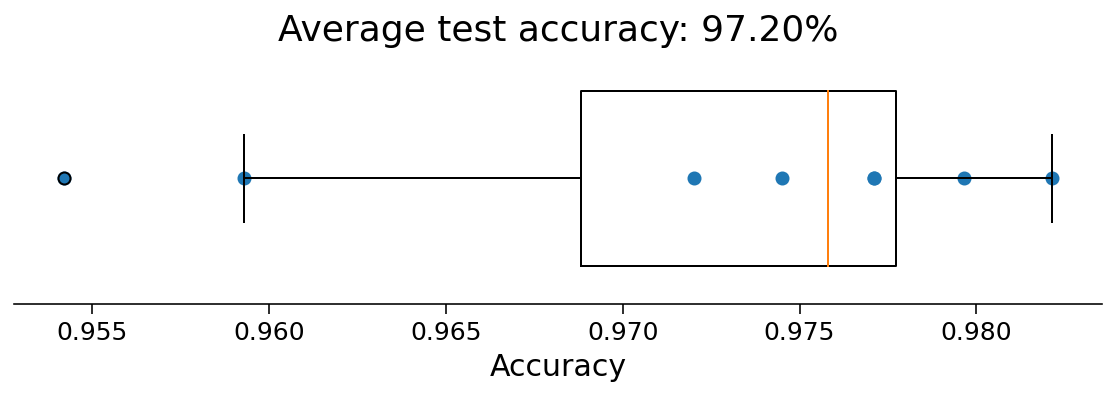

In [ ]:
## CROSS VALIDATION
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [ ]:
## sample subjects without replacement
train_list = np.random.choice(subs, size=272, replace=False)
test_list = np.setdiff1d(subs,train_list)

train_data = filter_behav_ts[np.isin(filter_behav_ts[:,2], train_list)]
test_data = filter_behav_ts[np.isin(filter_behav_ts[:,2], test_list)]

X_train = train_data[:,4:]
y_train = train_data[:,0]

X_test = test_data[:,4:]
y_test = test_data[:,0]

#print(np.shape(train1))
#print(np.shape(test1))
#print(np.shape(filter_behav_ts))


0.9777138749101366


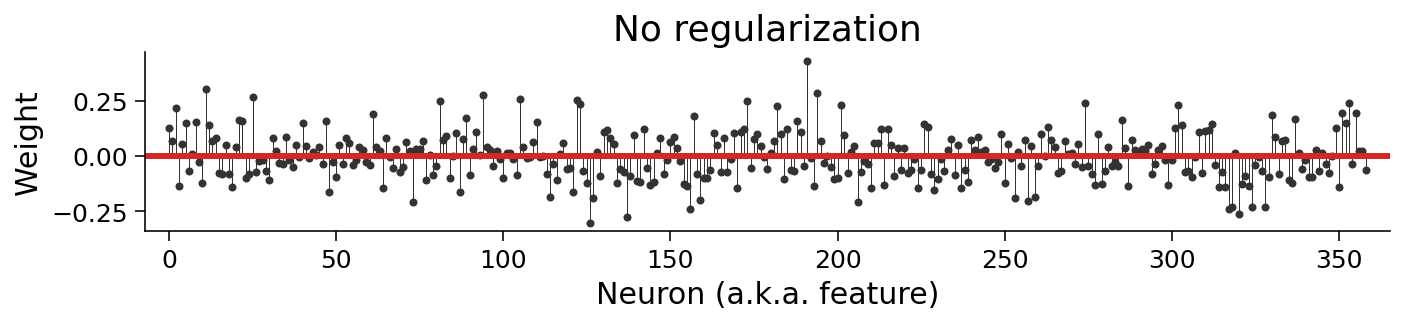

In [ ]:
## Fit model to train data, use predictions on test data

# run logistic regression on training dataset
log_reg_train = LogisticRegression(penalty="none")
log_reg_train.fit(X_train, y_train)

# predict test set (20% of held out participants) from training fit
y_pred = log_reg_train.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)

print(accuracy)

# plot weights
plot_weights({"No regularization": log_reg_train})

L2 regularization

In [ ]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1, solver="saga", max_iter=5000).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg_all,
  "$L_2$ (C = 1)": log_reg_l2,
}


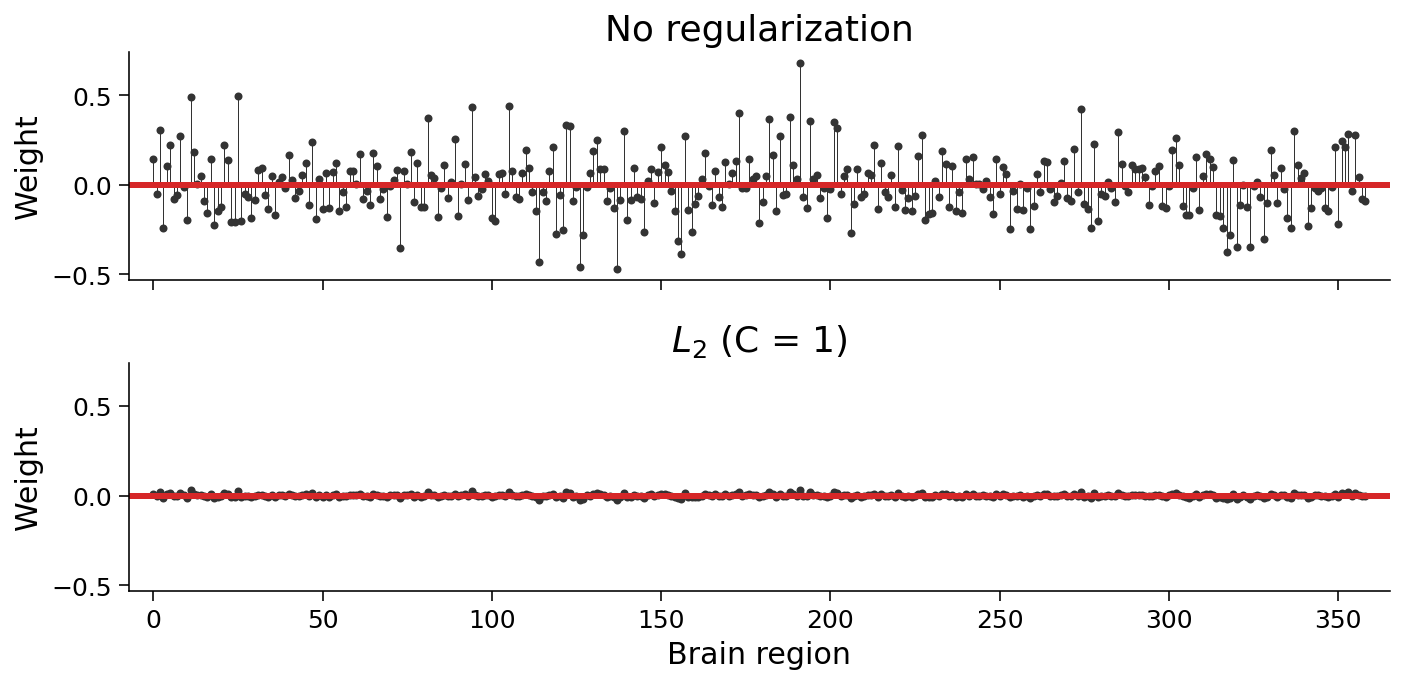

In [ ]:
plot_weights(models)

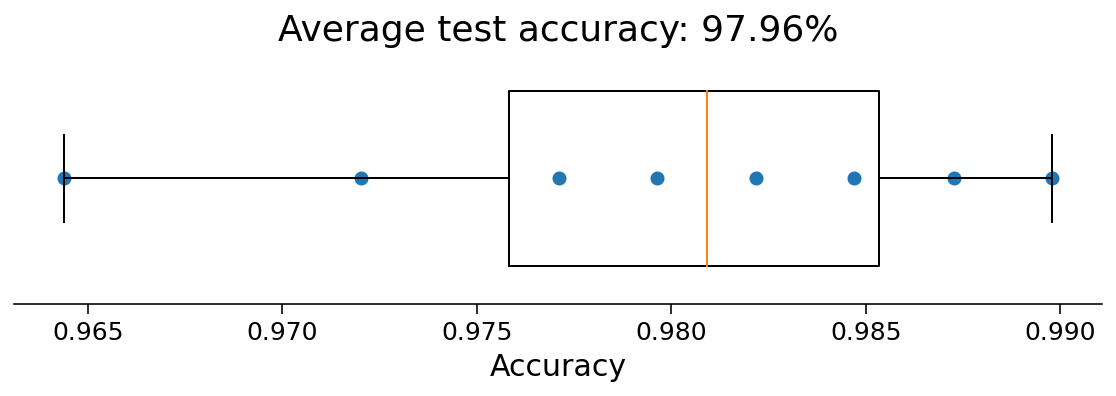

In [ ]:
## CROSS VALIDATION
accuracies = cross_val_score(log_reg_l2, X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

## Non_social Areas <br>
V1, A1, M1, FEF, piriform cortex, auditory complex <br>

This model should perform much more poorly and should be closer to chance (50%) than the full model. 

In [ ]:
## LOGISTIC REGRESSION TO CLASSIFY SOCIAL VS NON SOCIAL 
# Seperate into training & test set (by subject)
X = non_social_array[:,3:]
y = non_social_array[:,0]

print('X', np.shape(X))
print('y', np.shape(y))

# Logistic regression -- day 4 tutorial 2 
log_reg_all = LogisticRegression(penalty="none")
log_reg_all.fit(X, y)

X (3142, 18)
y (3142,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)
  accuracy = np.mean([y == y_pred])

  return accuracy

# Uncomment and run to test your function:
train_accuracy = compute_accuracy(X, y, log_reg_all)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 69.83%


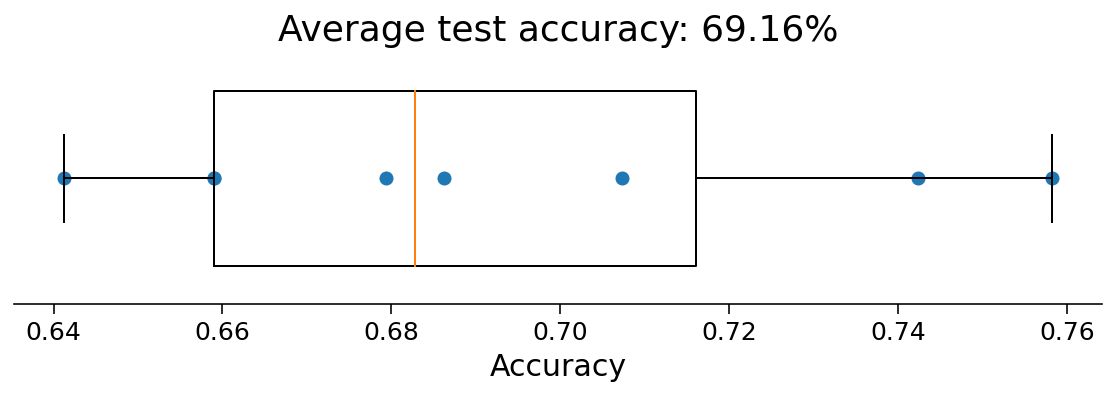

In [ ]:
## CROSS VALIDATION
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [ ]:
## sample subjects without replacement
train_list = np.random.choice(subs, size=272, replace=False)
test_list = np.setdiff1d(subs,train_list)

train_data = non_social_array[np.isin(non_social_array[:,2], train_list)]
test_data = non_social_array[np.isin(non_social_array[:,2], test_list)]

X_train = train_data[:,4:]
y_train = train_data[:,0]

X_test = test_data[:,4:]
y_test = test_data[:,0]

#print(np.shape(train1))
#print(np.shape(test1))
#print(np.shape(filter_behav_ts))


0.669059583632448


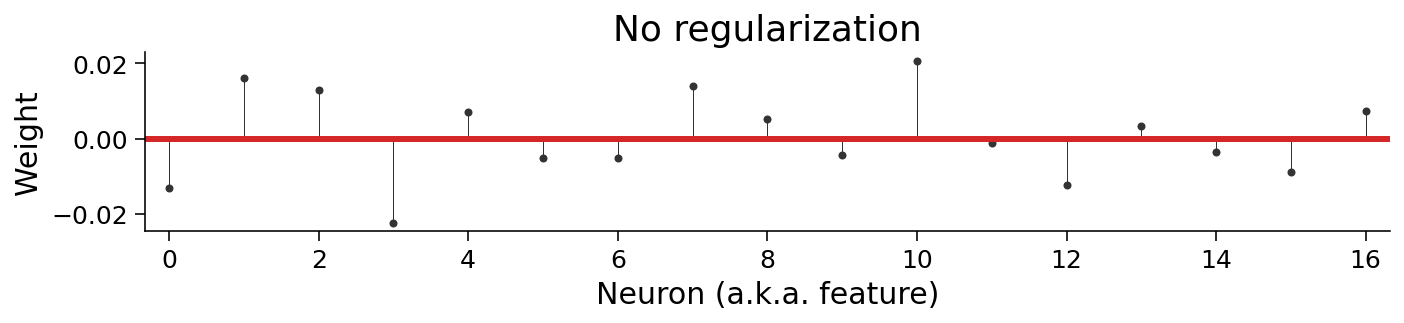

In [ ]:
## Fit model to train data, use predictions on test data

# run logistic regression on training dataset
log_reg_train = LogisticRegression(penalty="none")
log_reg_train.fit(X_train, y_train)

# predict test set (20% of held out participants) from training fit
y_pred = log_reg_train.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)

print(accuracy)

# plot weights
plot_weights({"No regularization": log_reg_train})

## Social Areas <br>

STS, TPJ, OFC, precuneus <br>
This model should outperform the non-social control brain regions above. However, we don't expect it to perform as well as our full model due to the lower number of parameters (brain regions; 360 vs. 18).

In [ ]:
## LOGISTIC REGRESSION TO CLASSIFY SOCIAL VS NON SOCIAL 
# Seperate into training & test set (by subject)
X = social_array[:,3:]
y = social_array[:,0]

print('X', np.shape(X))
print('y', np.shape(y))

# Logistic regression -- day 4 tutorial 2 
log_reg_all = LogisticRegression(penalty="none")
log_reg_all.fit(X, y)

X (3142, 18)
y (3142,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)
  accuracy = np.mean([y == y_pred])

  return accuracy

# Uncomment and run to test your function:
train_accuracy = compute_accuracy(X, y, log_reg_all)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 82.02%


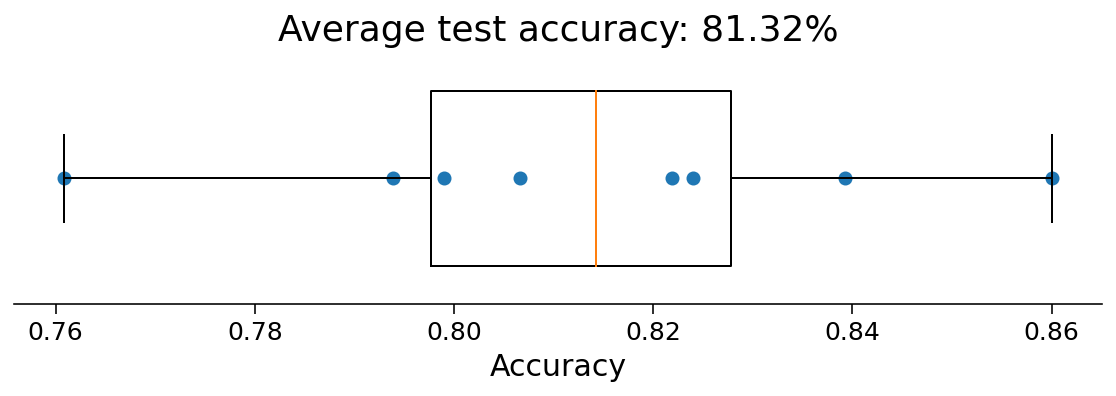

In [ ]:
## CROSS VALIDATION
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [ ]:
## sample subjects without replacement
train_list = np.random.choice(subs, size=272, replace=False)
test_list = np.setdiff1d(subs,train_list)

train_data = social_array[np.isin(social_array[:,2], train_list)]
test_data = social_array[np.isin(social_array[:,2], test_list)]

X_train = train_data[:,4:]
y_train = train_data[:,0]

X_test = test_data[:,4:]
y_test = test_data[:,0]

#print(np.shape(train1))
#print(np.shape(test1))
#print(np.shape(filter_behav_ts))

0.8125874125874126


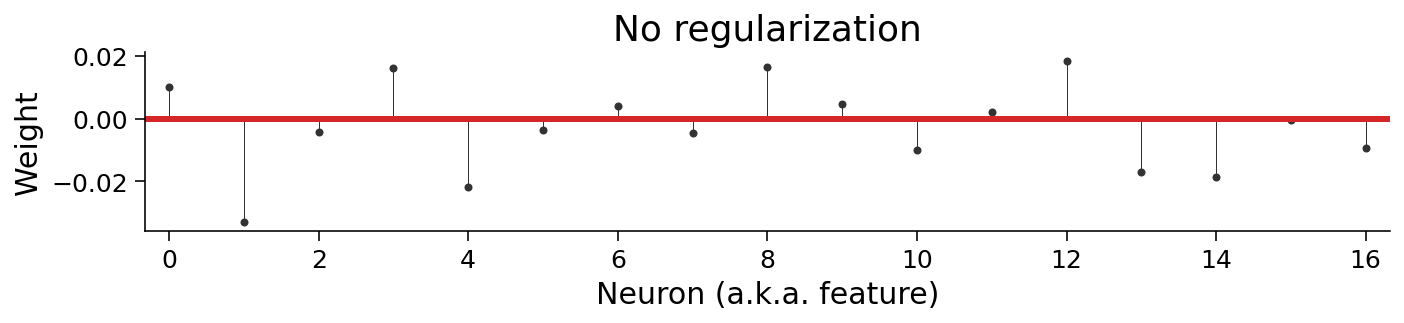

In [ ]:
## Fit model to train data, use predictions on test data

# run logistic regression on training dataset
log_reg_train = LogisticRegression(penalty="none")
log_reg_train.fit(X_train, y_train)

# predict test set (20% of held out partic  ipants) from training fit
y_pred = log_reg_train.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)

print(accuracy)

# plot weights
plot_weights({"No regularization": log_reg_train})

## TEST: OTHER higher order cortical areas: memory areas <br>
Hippocampus, ERC, PHC, vmPFC <br>
The logic is that the above could just reflect the difference between higher order association cortices and primary sensory/motor cortices. The data below suggest that this is NOT the case. Other regions supporting higher order cognition (i.e., memory) do not perform as well as the social areas in distinguishing these videos, but outperform the primary cortices (which is exactly what we might expect).

In [ ]:
## LOGISTIC REGRESSION TO CLASSIFY SOCIAL VS NON SOCIAL 
# Seperate into training & test set (by subject)
X = other_array[:,3:]
y = other_array[:,0]

print('X', np.shape(X))
print('y', np.shape(y))

# Logistic regression -- day 4 tutorial 2 
log_reg_all = LogisticRegression(penalty="none")
log_reg_all.fit(X, y)

X (3142, 18)
y (3142,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  #############################################################################
  # TODO Complete the function, then remove the next line to test it
  # raise NotImplementedError("Implement the compute_accuracy function")
  #############################################################################

  y_pred = model.predict(X)
  accuracy = np.mean([y == y_pred])

  return accuracy

# Uncomment and run to test your function:
train_accuracy = compute_accuracy(X, y, log_reg_all)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 77.34%


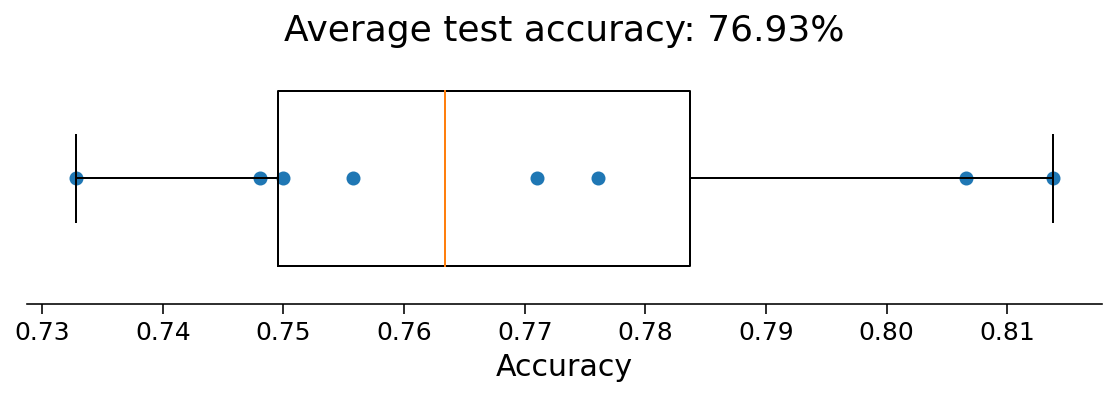

In [ ]:
## CROSS VALIDATION
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [ ]:
## sample subjects without replacement
train_list = np.random.choice(subs, size=272, replace=False)
test_list = np.setdiff1d(subs,train_list)

train_data = other_array[np.isin(other_array[:,2], train_list)]
test_data = other_array[np.isin(other_array[:,2], test_list)]

X_train = train_data[:,4:]
y_train = train_data[:,0]

X_test = test_data[:,4:]
y_test = test_data[:,0]

#print(np.shape(train1))
#print(np.shape(test1))
#print(np.shape(filter_behav_ts))

0.7559618441971383


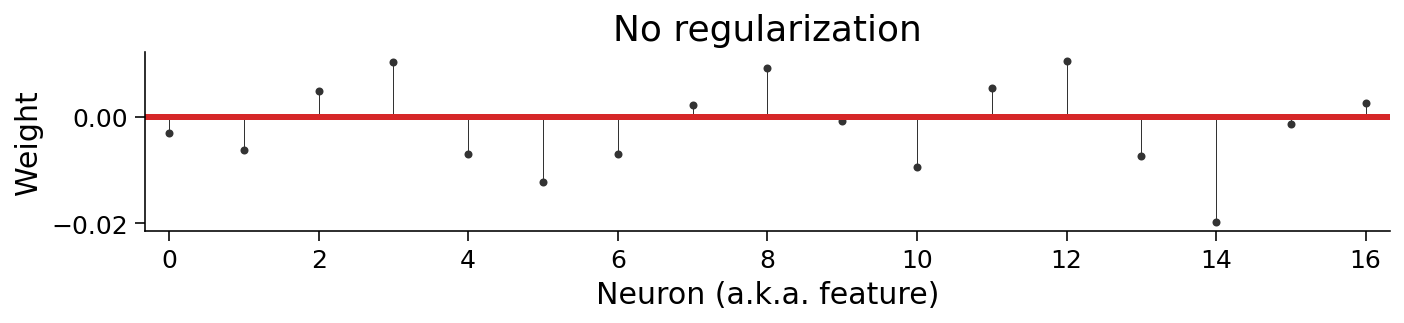

In [ ]:
## Fit model to train data, use predictions on test data

# run logistic regression on training dataset
log_reg_train = LogisticRegression(penalty="none")
log_reg_train.fit(X_train, y_train)

# predict test set (20% of held out partic  ipants) from training fit
y_pred = log_reg_train.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)

print(accuracy)

# plot weights
plot_weights({"No regularization": log_reg_train})

## **Analyze data**

In [ ]:
social_behavior = np.genfromtxt("hcp/behavior/social.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(social_behavior[:5])
print(social_behavior.dtype.names)

print(np.shape(social_behavior))

[(0, 0, 'RANDOM',  866.5,    nan, nan, 0., 1., 0., 0.)
 (0, 0, 'TOM',    nan, 1090. , nan, 0., 0., 1., 0.)
 (0, 1, 'RANDOM', 1355. ,    nan, nan, 0., 1., 0., 0.)
 (0, 1, 'TOM',    nan, 1619.5, nan, 0., 0., 1., 0.)
 (1, 0, 'RANDOM',  452. ,    nan, nan, 0., 1., 0., 0.)]
('Subject', 'Run', 'ConditionName', 'MEDIAN_RT_RANDOM', 'MEDIAN_RT_TOM', 'MEDIAN_RT_UNSURE', 'PROP_NLR', 'PROP_RANDOM', 'PROP_TOM', 'PROP_UNSURE')
(1356,)


In [ ]:
## DRAFT:

# task = "social"
# conditions = ["mental", "rnd", "mental_resp", "other_resp"]  # Run a substraction analysis between two conditions
# runs = [0, 1]
# regions = range(0,360)
# subject = 1
# run = 1

# # for subject in subjects:
# # for run in runs:
# current_data = load_timeseries(subject, 'social', runs=run, concat=True, remove_mean=True)
# nrow = len(current_data)
# evs = [load_evs(subject, task, cond) for cond in conditions]

# frames_concat = condition_frames(load_evs(subject, "social", "rnd"), skip=0)
# framestemp = frames_concat[run]

# print(frames_concat)
# print(np.shape(frames_concat))

# print(framestemp)
# print(np.shape(framestemp))

# # onsets_social.append(frames_concat)

# # current_data_test = current_data[framestemp]
# # print(current_data_test)
# # print(np.shape(current_data_test))

# # print(conditionframes)

# # print(evs)
# # print(np.shape(evs))
# # for region in regions:
# #   region_data = current_data[region,:]
# # # print(subject, run)
# # # print(subject,run,np.shape(current_data))
# #   print(run, region, np.mean(region_data))

## Run a simple subtraction analysis

In [ ]:
task = "social"
conditions = ["mental", "rnd"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

NameError: ignored

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

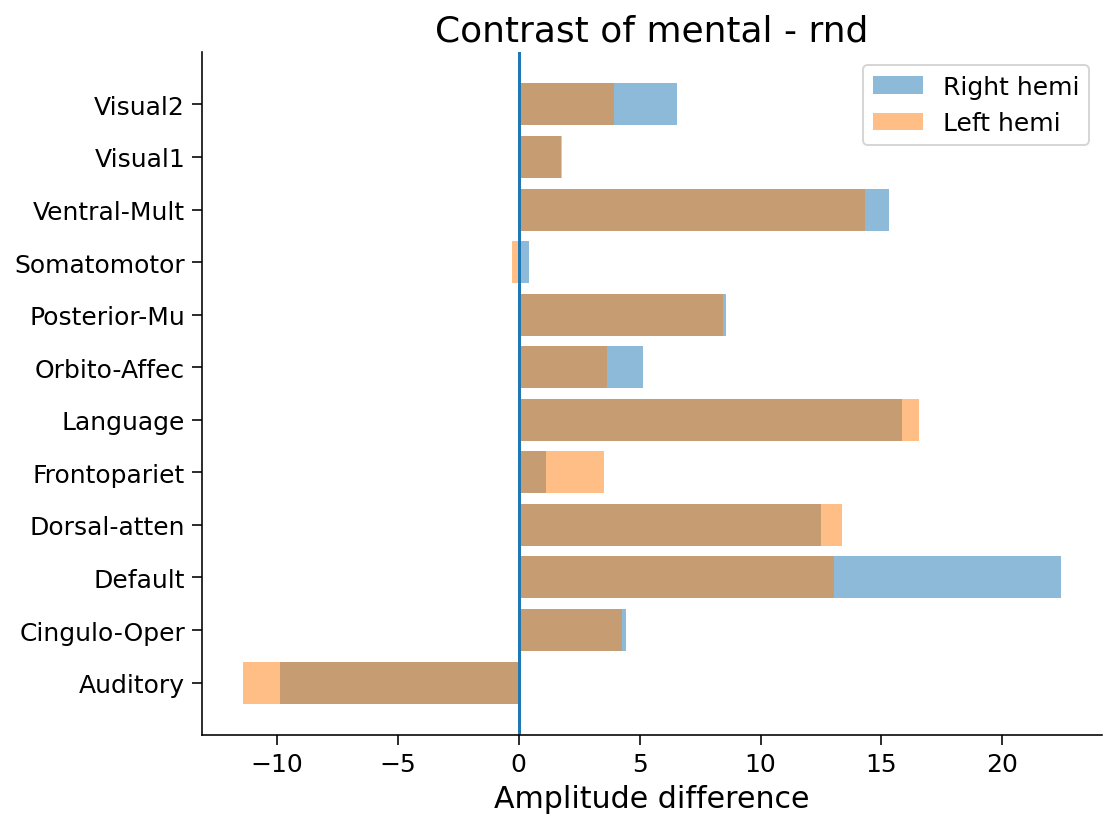

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
# wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
#                             delimiter=",",
#                             names=True,
#                             dtype=None,
#                             encoding="utf")
# print(wm_behavior[:5])
# print(wm_behavior.dtype.names)

[(0, 0, '0BK_BODY', 1., 1., 1.,  705.5,  740.5, 696. )
 (0, 0, '0BK_FACE', 1., 1., 1.,  779.5,  765. , 915. )
 (0, 0, '0BK_PLACE', 1., 1., 1.,  926. ,  993.5, 811.5)
 (0, 0, '0BK_TOOL', 1., 1., 1.,  807.5,  807.5, 807.5)
 (0, 0, '2BK_BODY', 1., 1., 1., 1133. , 1205.5, 732.5)]
('Subject', 'Run', 'ConditionName', 'ACC', 'ACC_NONTARGET', 'ACC_TARGET', 'MEDIAN_RT', 'MEDIAN_RT_NONTARGET', 'MEDIAN_RT_TARGET')


In [ ]:
social_behavior = np.genfromtxt("hcp/behavior/social.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(social_behavior[:5])
print(social_behavior.dtype.names)

[(0, 0, 'RANDOM',  866.5,    nan, nan, 0., 1., 0., 0.)
 (0, 0, 'TOM',    nan, 1090. , nan, 0., 0., 1., 0.)
 (0, 1, 'RANDOM', 1355. ,    nan, nan, 0., 1., 0., 0.)
 (0, 1, 'TOM',    nan, 1619.5, nan, 0., 0., 1., 0.)
 (1, 0, 'RANDOM',  452. ,    nan, nan, 0., 1., 0., 0.)]
('Subject', 'Run', 'ConditionName', 'MEDIAN_RT_RANDOM', 'MEDIAN_RT_TOM', 'MEDIAN_RT_UNSURE', 'PROP_NLR', 'PROP_RANDOM', 'PROP_TOM', 'PROP_UNSURE')


## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

(339, 25)